<a href="https://colab.research.google.com/github/kumarchandan/END/blob/main/week14/English-to-Python-Code-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
### Train a model to generate python code from english text

In [203]:
!nvidia-smi

Mon Mar 22 18:59:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |   5156MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load libraries

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import gensim
import numpy as np

import random
import math
import time
import os
import tokenize
import re
import pandas as pd
import csv
from tqdm import tqdm_notebook
from tokenize import tokenize, untokenize
import io

In [2]:
torchtext.__version__

'0.9.0'

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data

In [5]:
corpus_name = 'english-python'
corpus = os.path.join('/content/drive/MyDrive/1-Projects/END/week14/', corpus_name)

def printLines(file,):
  count = 0
  with open(file, 'rb') as f:
    for line in f:
      print(line)
      count += 1
      if count == 10: break

printLines(os.path.join(corpus, 'data_refined_v1.txt'))

b'# write a python program to add two numbers\n'
b'num1 = 1.5\n'
b'num2 = 6.3\n'
b'sum = num1 + num2\n'
b"print(f'Sum: {sum}')\n"
b'\n'
b'\n'
b'# write a python function to add two user provided numbers and return the sum\n'
b'def add_two_numbers(num1, num2):\n'
b'    sum = num1 + num2\n'


In [6]:
corpus_name = 'english-python'
corpus = os.path.join('/content/drive/MyDrive/1-Projects/END/week14/', corpus_name)

def extractQnAPair(file):
  qna_pair_list = []
  qna_pair = { 'src': '', 'trg': ''}
  count = 0
  regex = r"#"
  str = ''
  with open(file, 'r') as f:
    for line in f:
      line = line.lower()
      line = re.sub(r'"#[0123456789]','#', line)
      line = line.replace("\n\n","\n")
      line = line.replace("\n\n\n","\n\n")
      ques_found = re.search(regex, line)
      if ques_found:
        if (qna_pair['src'] and qna_pair['trg']): qna_pair_list.append(qna_pair)
        qna_pair = { 'src': '', 'trg': ''}
        qna_pair['id'] = count
        qna_pair['src'] = line
        qna_pair['trg'] = ''
        count += 1
      else:
        qna_pair['trg'] += line
  return qna_pair_list

qna_pair_list = extractQnAPair(os.path.join(corpus, 'data_refined_v1.txt'))

In [7]:
len(qna_pair_list), qna_pair_list[0]

(4445,
 {'id': 0,
  'src': '# write a python program to add two numbers\n',
  'trg': "num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\nprint(f'sum: {sum}')\n\n\n"})

In [8]:
df = pd.DataFrame(qna_pair_list)
df.head()

,src,trg,id
0,# write a python program to add two numbers\n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,0
1,# write a python function to add two user prov...,"def add_two_numbers(num1, num2):\n sum = nu...",1
2,# write a program to find and print the larges...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...,2
3,# write a program to find and print the smalle...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...,3
4,# write a python function to merge two given l...,"def merge_lists(l1, l2):\n return l1 + l2\n...",4


In [9]:
# print(qna_pair_list[0].keys()) # dict_keys(['question_id', 'question', 'answer'])
keys = qna_pair_list[0].keys()

shouldExecute = True
if shouldExecute:
  with open('python_qna.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(qna_pair_list)
else:
  print('did not execute')

In [ ]:
!python -m spacy download en

In [11]:
spacy_en = spacy.load('en')

In [13]:
SRC = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

fields = [("src", SRC), ("trg", TRG)]

In [14]:
dataset = TabularDataset(
    path='python_qna.csv',
    format='csv',
    fields=fields,
    skip_header=True
)
(train_data, valid_data) = dataset.split(split_ratio=[0.85, 0.15])

In [15]:
vars(train_data[0])

{'src': ['#',
  'write',
  'a',
  'python',
  'program',
  'to',
  'print',
  'the',
  'character',
  'of',
  'an',
  'ascii',
  'value'],
 'trg': ['value',
  '=',
  '65',
  '\n',
  "print(f'the",
  'ascii',
  'value',
  '{',
  'value',
  '}',
  'is',
  'of',
  'the',
  'character',
  '{',
  'chr(value',
  ')',
  '}',
  "'",
  ')']}

To decide maxlength for encoder and decoder

In [16]:
max_len_src = 0
max_len_trg = 0

for data in train_data:
  if len(data.src) > max_len_src:
    max_len_src = len(data.src)
  if len(data.trg) > max_len_trg:
    max_len_trg = len(data.trg)

max_len_src, max_len_trg

(84, 488)

In [17]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 1)

In [18]:
print('Source vocab size: ', len(SRC.vocab))
print('Target vocab size: ', len(TRG.vocab))

Source vocab size:  1509
Target vocab size:  10034


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
BATCH_SIZE = 8

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

In [21]:
vars(train_iterator.dataset.examples[0])

{'src': ['#',
  'write',
  'a',
  'python',
  'program',
  'to',
  'print',
  'the',
  'character',
  'of',
  'an',
  'ascii',
  'value'],
 'trg': ['value',
  '=',
  '65',
  '\n',
  "print(f'the",
  'ascii',
  'value',
  '{',
  'value',
  '}',
  'is',
  'of',
  'the',
  'character',
  '{',
  'chr(value',
  ')',
  '}',
  "'",
  ')']}

### Code embeddings

https://medium.com/@rohit_agrawal/using-fine-tuned-gensim-word2vec-embeddings-with-torchtext-and-pytorch-17eea2883cd

In [22]:
def tokenize_code(text):
    """
    Replace and Tokenize
    """
    text = str(text).replace('\n', '\t\t')
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [23]:
# WORD2VEC
W2V_SIZE = 256
W2V_WINDOW = 3
# W2V_EPOCH = 100
W2V_MIN_COUNT = 2

target = []
for code in df['trg'].values:
  code_token = tokenize_code(code)
  target.append(code_token)

In [24]:
target[:1]

[['num1',
  '=',
  '1.5',
  '\t\t',
  'num2',
  '=',
  '6.3',
  '\t\t',
  'sum',
  '=',
  'num1',
  '+',
  'num2',
  '\t\t',
  "print(f'sum",
  ':',
  '{',
  'sum',
  '}',
  "'",
  ')',
  '\t\t\t\t\t\t']]

In [25]:
w2v_model = gensim.models.Word2Vec(target, size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)

In [26]:
word2vec_vectors = []

for token, idx in tqdm_notebook(TRG.vocab.stoi.items()):
  if token in w2v_model.wv.vocab.keys():
    word2vec_vectors.append(torch.FloatTensor(w2v_model[token]))
  else:
    word2vec_vectors.append(torch.zeros(W2V_SIZE))

TRG.vocab.set_vectors(TRG.vocab.stoi, word2vec_vectors, W2V_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  """


### Build Model

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [28]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 250):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [30]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [31]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

## Decoder

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [32]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 pre_trained_emb,
                 max_length = 500):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding.from_pretrained(pre_trained_emb)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [33]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [34]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

### Train the model

In [35]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

pre_trained_emb = torch.FloatTensor(TRG.vocab.vectors)

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device,
              pre_trained_emb)

In [36]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,110,706 trainable parameters


In [38]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [39]:
model.apply(initialize_weights);

In [40]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [41]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [42]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [43]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'eng-python-model-v1.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 3.538 | Train PPL:  34.402
	 Val. Loss: 3.375 |  Val. PPL:  29.229
Epoch: 02 | Time: 0m 16s
	Train Loss: 3.084 | Train PPL:  21.851
	 Val. Loss: 3.073 |  Val. PPL:  21.596
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.737 | Train PPL:  15.443
	 Val. Loss: 2.845 |  Val. PPL:  17.205
Epoch: 04 | Time: 0m 16s
	Train Loss: 2.442 | Train PPL:  11.499
	 Val. Loss: 2.689 |  Val. PPL:  14.715
Epoch: 05 | Time: 0m 16s
	Train Loss: 2.193 | Train PPL:   8.966
	 Val. Loss: 2.569 |  Val. PPL:  13.057
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.977 | Train PPL:   7.221
	 Val. Loss: 2.447 |  Val. PPL:  11.553
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.794 | Train PPL:   6.015
	 Val. Loss: 2.383 |  Val. PPL:  10.839
Epoch: 08 | Time: 0m 16s
	Train Loss: 1.644 | Train PPL:   5.175
	 Val. Loss: 2.310 |  Val. PPL:  10.074
Epoch: 09 | Time: 0m 16s
	Train Loss: 1.504 | Train PPL:   4.500
	 Val. Loss: 2.274 |  Val. PPL:   9.720
Epoch: 10 | Time: 0m 16s
	Train Loss: 1.406 | Train PPL

### Test the model

In [118]:
def generate_code(sentence, src_field, trg_field, model, device, max_len = 80):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [51]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(30,50))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [148]:
example_idx = 47

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['#', 'write', 'a', 'python', 'function', 'to', 'convert', 'a', 'string', 'to', 'a', 'list']
trg = ['def', 'convert_str_to_list(string', ')', ':', '\n    ', 'return', 'string.split', '(', "'", "'", ')']


In [149]:
code_snippet, attention = generate_code(src, SRC, TRG, model, device)

print(f'predicted trg = {code_snippet}')

predicted trg = ['def', 'convert_str_to_list(string', ')', ':', '\n    ', 'return', 'string.split', '(', "'", "'", ')', ')', '<eos>']


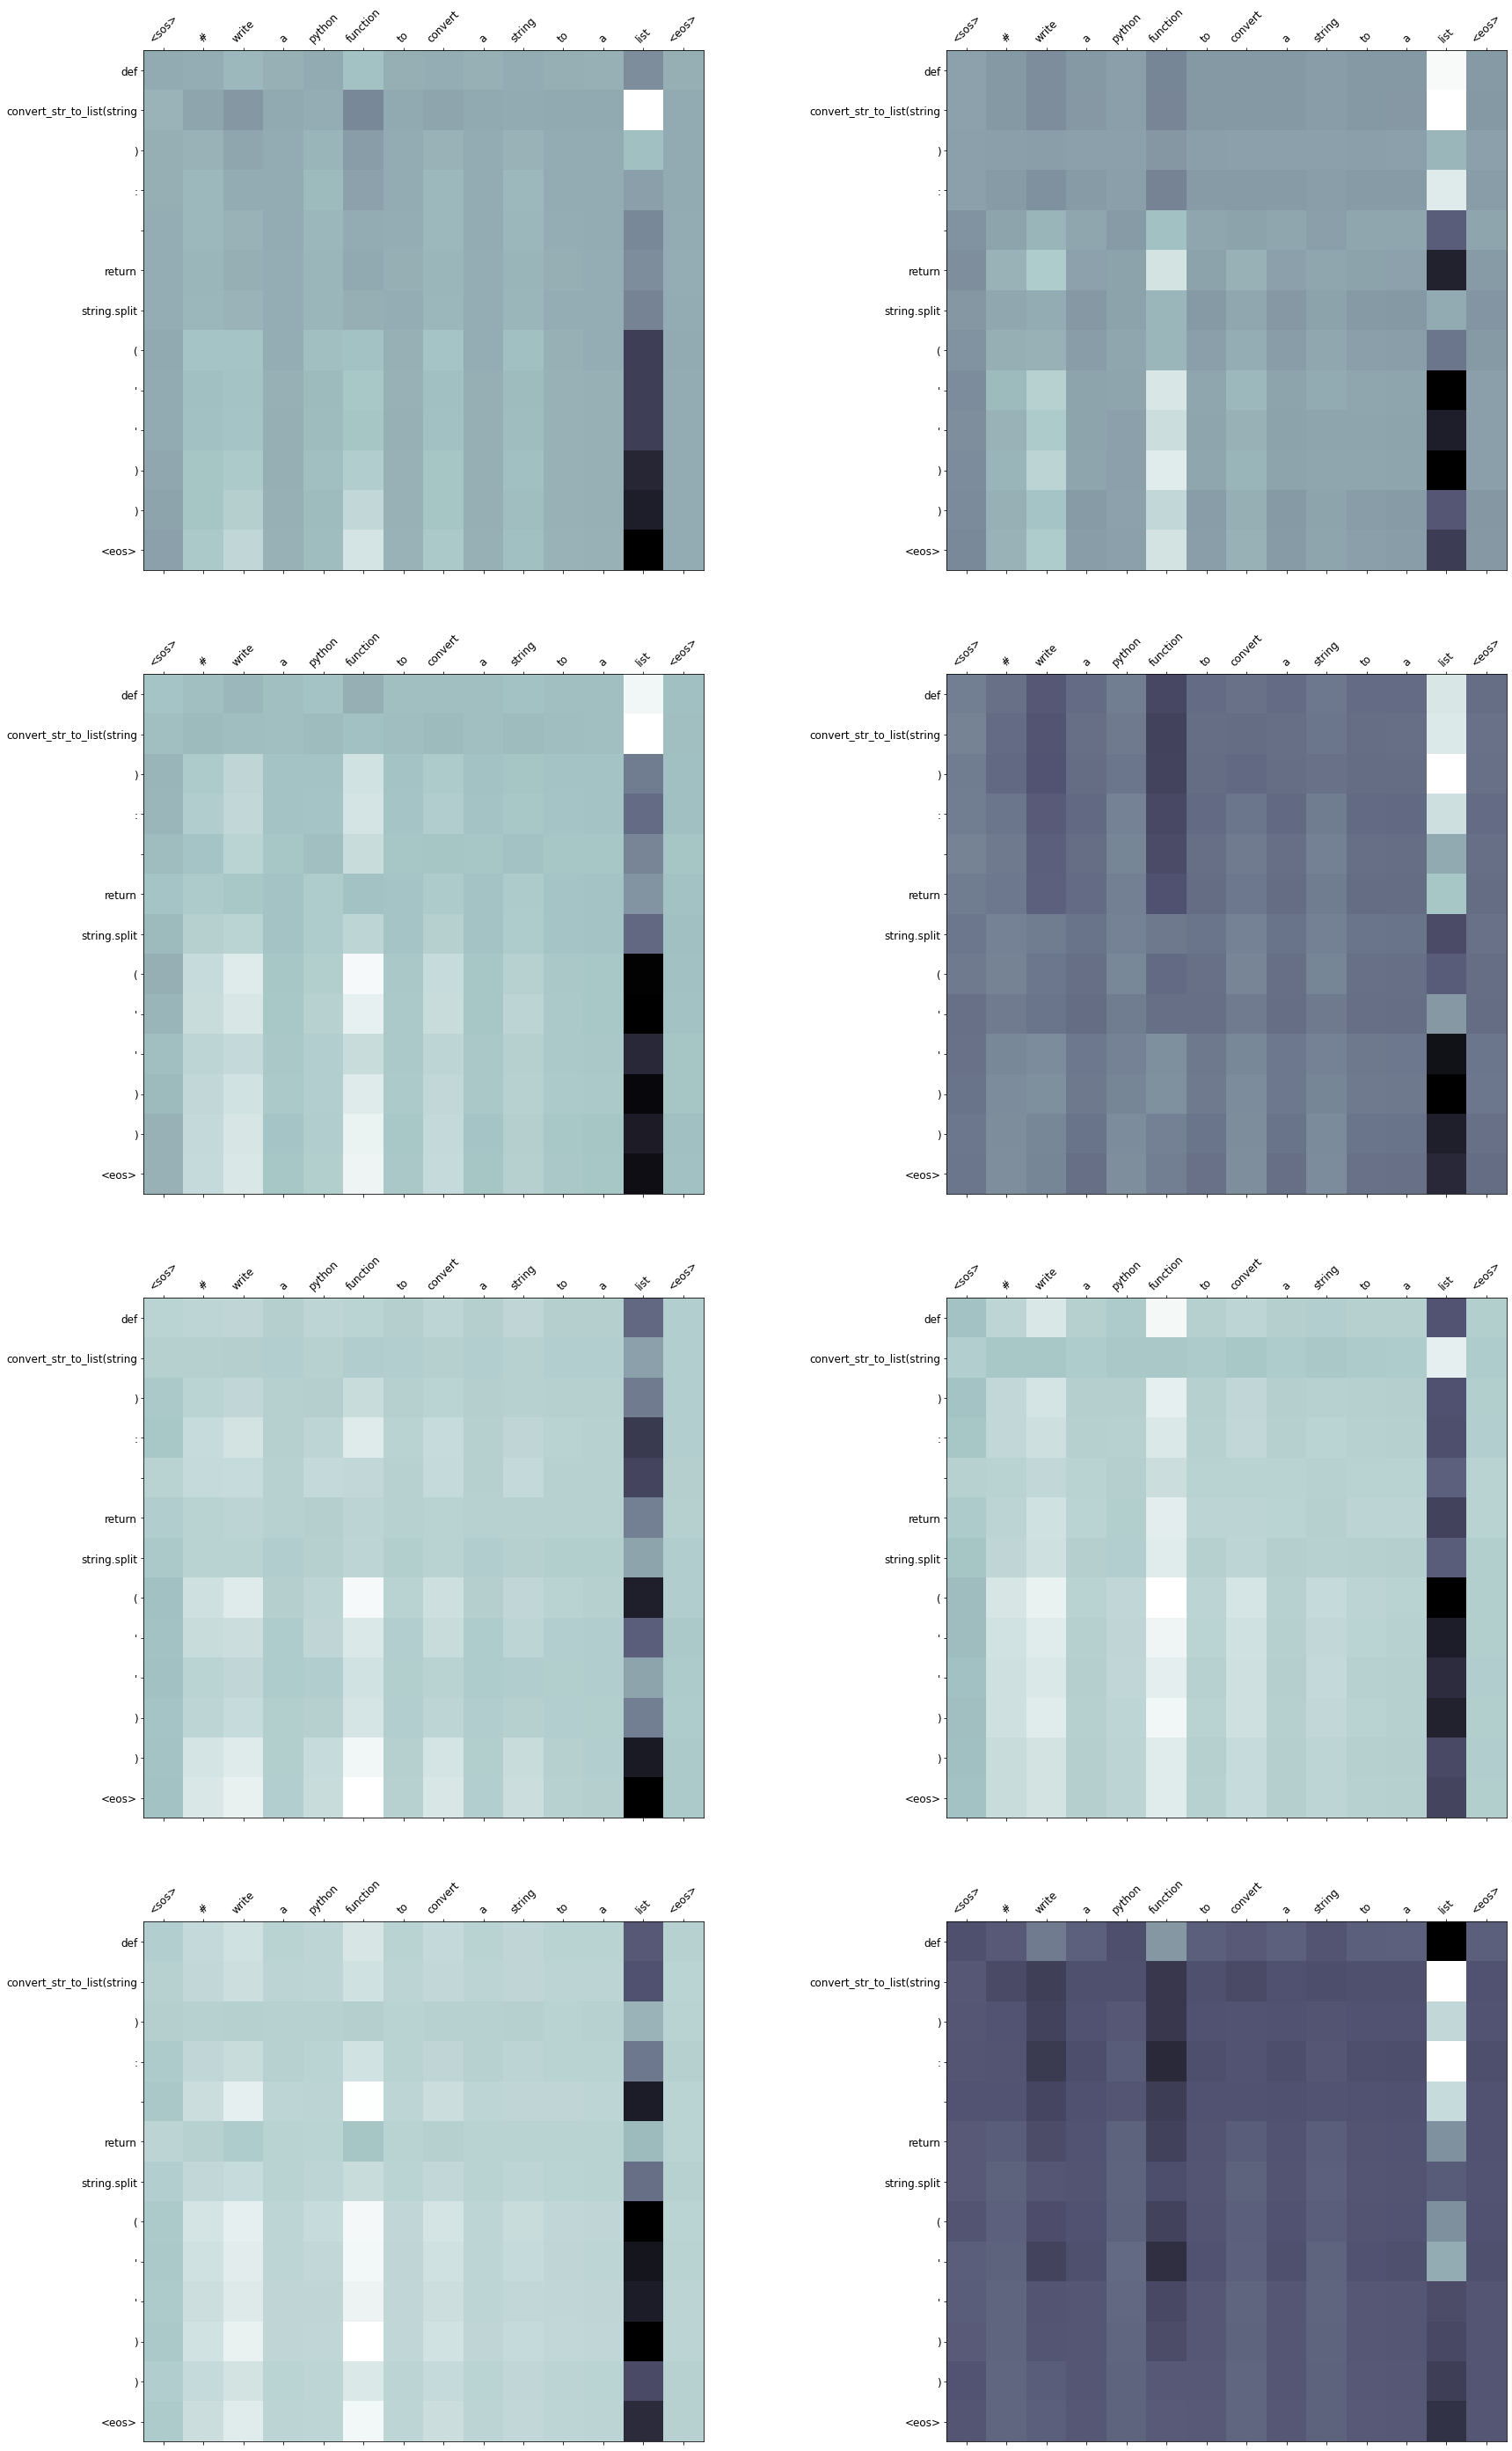

In [150]:
display_attention(src, code_snippet, attention)

### Examples

Example: 1

In [205]:
input_text = 'write a function to return the perimeter of a isoscales triangle'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the perimeter of a isoscales triangle
---
def cal_perimeter_iso_triangle(s1,s2 ) : 
     return 2*s1+s2 


Example: 2

In [169]:
input_text = 'write a python function to add two numbers'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a python function to add two numbers
---
def add_two_numbers(num1 , num2 ) : 
     sum = num1 + num2 
     return sum 


Example: 3

In [204]:
input_text = 'write a function to return the area of an ellipse'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the area of an ellipse
---
def cal_area_ellipse(minor , major ) : 
     pi = 3.14 
     return pi*(minor*major ) 


Example: 4

In [207]:
input_text = 'write a function to return the perimeter of an equilateral triangle'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the perimeter of an equilateral triangle
---
def cal_perimeter_eq_triangle(a ) : 
     return 3*a 


Example: 5

In [208]:
input_text = 'write a function to return the surface area of a sphere'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the surface area of a sphere
---
def cal_area_sphere(radius ) : 
     pi = 3.14 
     return 4*pi*(radius**2 ) 


Example: 6

In [209]:
input_text = 'write a function to return the total surface area of a cylinder'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the total surface area of a cylinder
---
def cal_cylinder_volume(height , radius ) : 
     pi=3.14 
     return pi*(radius**2)*height 


Example: 7

In [211]:
input_text = 'write a function to return the area of triangle by heros formula'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the area of triangle by heros formula
---
def cal_triangle_area(a : float , b : float , c : float)->float : 
     if a or b or c : 
         s = ( a+b+c)/2 
         if s > a and s > b and s > c : 
             area = ( s*(s - a)*(s - b)*(s - c))**(1/2 ) 
             return round(area,2 ) 
         else : 
             return none 
     return none 


Example: 8

In [212]:
input_text = 'write a function to return the cartisian distance between two points'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to return the cartisian distance between two points
---
def cal_cart_distance(x1 : float , y1 : float , x2 : float , y2 : float)->float : 
     return ( ( x1-x2)**2+(y1-y2)**2)**(1/2 ) 


Example: 9

In [262]:
input_text = 'function to find fibonacci sequence'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

function to find fibonacci sequence
---

 def fibonacci(n ) : 
     if n<0 : 
         print("incorrect input " ) 

     elif n==0 : 
         return 0 

     elif n==0 : 
         return 1 
     else : 
         return fibonacci(n-1)+fibonacci(n-2 ) 



 print(fibonacci(9 ) ) 


Example: 10

In [227]:
input_text = 'function to validate email address using regex'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

function to validate email address using regex
---

 import re 

 regex = ' ^[a - z0 - 9]+[\._]?[a - z0 - 9]+[@]\w+[.]\w{2,3}$ ' 
 def check(email ) : 
     if(re.search(regex , email ) ) : 
         print("valid email " ) 
     else : 
         print("invalid email " ) 


Example: 11

In [232]:
input_text = 'write a function to find factorial'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to find factorial
---

 def factorial(n ) : 
     if n = = 1 : 
         return 1 
     else : 
         return n * factorial(n - 1 ) 


Example: 12

In [279]:
input_text = 'Write a function to adds two lists element wise'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a function to adds two lists element wise
---
def sub_listelements(l1 : list , l2 : list ) : 
     return [ i+j for i , j in zip(l1,l2 ) ] 


Example: 13

In [236]:
input_text = 'write a function to capitalize a string'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a function to capitalize a string
---

 def capitalize(s , lower_rest = false ) : 
   return ' ' .join([s[:1].upper ( ) , ( s[1:].lower ( ) if lower_rest else s[1 : ] ) ] ) 


Example: 14

In [237]:
input_text = 'write a Python function to find the single number in a list that doesnt occur twice'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a Python function to find the single number in a list that doesnt occur twice
---
def single_number(arr ) : 
     result = 0 
     for i in arr : 
         result ^= i 
     return result 


Example: 15

In [277]:
input_text = 'Write a function to return the area of a equilateral triangle'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a function to return the area of a equilateral triangle
---
def cal_eq_triangle_area(a : float)->float : 
     if a : 
         return ( 3**(1/2))*(a**2)/4 
     else : 
         return none 


Example: 16

In [241]:
input_text = 'Write a program to check whether a file/path/direcory exists or not'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a program to check whether a file/path/direcory exists or not
---
file_path = " path / here " 
 import os.path 
 os.path.exists(file_path ) 


Example: 17

In [271]:
input_text = 'Write a function to find volume of a cuboid'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a function to find volume of a cuboid
---
def cal_cuboid_volume(length : float , breadth : float)->float : 
     return length*breadth*height / length 


Example: 18

In [243]:
input_text = 'Write a function to calculate volume of Triangular Pyramid'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a function to calculate volume of Triangular Pyramid
---
def volumetriangular(a , b , h ) : 
     return ( 0.1666 ) * a * b * h 


Example: 19

In [246]:
input_text = 'Write a python function to determine if a year is leap year or not'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a python function to determine if a year is leap year or not
---

 year = int(input("enter a year : ") ) 
 if ( year % 4 ) = = 0 : 
    if ( year % 100 ) = = 0 : 
        if ( year % 400 ) = = 0 : 
            print(f"{year } is a leap year " ) 
        else : 
            print(f"{year } is not a leap year " ) 
    else : 
        print(f"{year } is not a leap year " ) 
 else :


Example: 20

In [248]:
input_text = 'Write a python function to find gcd using eucliean algorithm'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a python function to find gcd using eucliean algorithm
---

 def compute_gcd(x , y ) : 
     if x > y : 
         smaller = y 
     else : 
         smaller = x 
     for i in range(1,smaller + 1 ) : 
         if((x % i = = 0 ) and ( y % i = = 0 ) ) : 
             hcf = i 
     return hcf 

 num1 = 54 
 num2 = 24 

 print("the h.c.f . is " , compute_hcf(num1 , num2 ) ) 


Example: 21

In [249]:
input_text = 'Write a python program to flatten  a multidimensional list'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a python program to flatten  a multidimensional list
---
mylist = [ 1 , 2 , 3 , 4 , 5 ] 
 mylist = [ i for i in mylist if i ] 


Example: 22

In [266]:
input_text = 'Write a program to check whether a number is prime or not'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

Write a program to check whether a number is prime or not
---

 num = 407 


 if num > 1 : 
    for i in range(2,num ) : 
        if ( num % i ) = = 0 : 
            print(num,"is not a prime number " ) 
            print(i,"times",num//i,"is",num ) 
            break 
    else : 
        print(num,"is a prime number " ) 

 else : 
    print(num,"is not a prime number " ) 


Example: 23

In [263]:
input_text = 'write a program to find and print the largest among three numbers'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a program to find and print the largest among three numbers
---

 num1 = 10 
 num2 = 12 
 num3 = 14 
 if ( num1 > = num2 ) and ( num1 > = num3 ) : 
    largest = num1 
 elif ( num2 > = num1 ) and ( num2 > = num3 ) : 
    largest = num2 
 else : 
    largest = num3 
 print(f'largest:{largest } ' ) 


Example: 24

In [194]:
input_text = 'write a python function to calculate simple interest'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a python function to calculate simple interest
---
def simple_interest(p , t , r ) : 
     si = ( p * t * r)/100 
     return si 


Example: 25

In [259]:
input_text = 'write a python program to print all numbers in an interval'

print(input_text)
print('---')
code_snippet, attention = generate_code(input_text, SRC, TRG, model, device)
print(' '.join(code_snippet).replace('<eos>', ''))

write a python program to print all numbers in an interval
---
num = 12 
 for i in range(1 , 11 ) : 
    print(num , i , i , i , ' = ' , num*i ) 


--- END ---